In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
configurationFile = './configurations/01_tgv.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

In [12]:
nx = 128
L = 1
u_mag = 2
k = 1 * np.pi
TGV_override = False
targetRe = 2000

config['domain']['minExtent'] = -L
config['domain']['maxExtent'] =  L

config['particle'] = {'nx' : nx}
config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cuda'}
config['plot']['export'] = True
# config['compute'] = {'device': 'cpu'}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)
setViscosityParameters(config, targetRe, L, u_mag)

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


Re = 2000.0, $\nu_{sph} = 0.002$, $\alpha = 0.010793905093535155$


In [13]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

particleState, mask = sampleParticles(config, sdfs = [])

priorState = None
particleState['velocities'][:,0] =  u_mag * torch.cos(k * particleState['positions'][:,0]) * torch.sin(k * particleState['positions'][:,1])
particleState['velocities'][:,1] = -u_mag * torch.sin(k * particleState['positions'][:,0]) * torch.cos(k * particleState['positions'][:,1])

u_max = torch.linalg.norm(particleState['velocities'], dim = 1).max()
particleState['velocities'] = particleState['velocities'] / (u_max + 1e-7) * u_mag
Ek0 = 0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(particleState['velocities'], dim = -1)**2

initialVelocities = particleState['velocities'].clone()

particleState['Eks'] =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2)
particleState['E_k'] = particleState['Eks'].sum().cpu().detach().item()

# perennialState = {
#     'fluid': copy.deepcopy(particleState),
#     'time': 0.0,
#     'timestep': 0,
#     'dt': config['timestep']['dt'],
# }
# del particleState['neighborhood']


In [14]:
# config['regions'] = None

Setting up initial plot
Computing visualization state
Setting up plot A
Setting up plot B
Done setting up initial plot


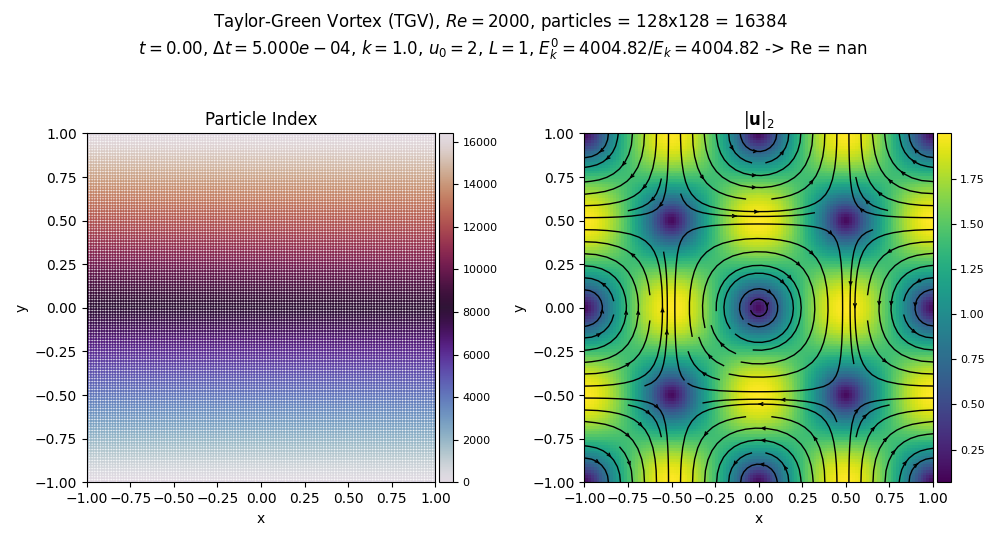

In [15]:
from diffSPH.v2.plotting import updatePlots
from diffSPH.v2.runner import runSimulation, setupSimulation

def callBackFn(perennialState, particleState, config, plotStates, fig, axis, frameStatistics):
    E_k = perennialState['fluid']['E_k']
    nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
    Re = u_mag * 2 / nu_total
    title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {E_k:.2f}$ -> Re = {Re}')

config['timestep']['active'] = False
config['timestep']['dt'] = 5e-4
initialState = {
    'fluid': particleState,
    'time': 0.0,
    'timestep': 0,
    'dt': torch.tensor(5e-4, device = config['compute']['device']),
}

from diffSPH.v2.plotting import setupInitialPlot

perennialState = copy.deepcopy(initialState)
fig, axis, plotStates = setupInitialPlot(initialState, initialState, config)
priorState = None

E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
Re = u_mag * 2 / nu_total

title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')
fig.tight_layout()

# updatePlots(perennialState, particleState, config, plotStates, fig, axis)
stats = []

In [16]:
from diffSPH.v2.plotting import exportPlot, postProcessPlot
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing
from diffSPH.v2.simulationSchemes.deltaPlus import checkNaN

priorState = None
for i in tqdm(range(4096)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    perennialState['fluid']['shiftAmount'] = dx
    perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]
    if config['compute']['checkNaN']:
        checkNaN(perennialState['fluid']['positions'], 'positions')
        checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    
    # perennialState = simulationStep(perennialState, config)
    # perennialState['fluidGhostParticles'] = buildOutletGhostParticles(regions, perennialState, config)


    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    # fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')
    # perennialState['fluid']['positions'] += perennialState['fluid']['velocities'] * config['timestep']['dt']

    perennialState['fluid']['Eks'] = (0.5 * perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = -1)**2)
    perennialState['fluid']['E_k'] = perennialState['fluid']['Eks'].sum().detach().cpu().item()
    frameStatistics = computeStatistics(perennialState, particleState, config)
    
    ttime = perennialState['time'] if not isinstance(perennialState['time'], torch.Tensor) else perennialState['time'].cpu().item()
    stats.append(frameStatistics)

    if i % 32 == 0:
        callBackFn(perennialState, particleState, config, plotStates, fig, axis, frameStatistics)
        updatePlots(perennialState, particleState, config, plotStates, fig, axis, title = '')

        # printState(perennialState)
        # print(f'Iteration {i}')
        # visualizationState = prepVisualizationState(perennialState, config)
        # updatePlot(indexPlot, visualizationState, 'densities')
        # updatePlot(quantPlot, visualizationState, 'velocities')
        # fig.canvas.draw()
        # fig.canvas.flush_events()
        # exportPlot(perennialState, config, fig)
    if 'regions' in config and config['regions'] is not None:
        for emitter in config['regions']:
            if emitter['type'] == 'inlet':
                processInlet(perennialState, emitter)
            if emitter['type'] == 'outlet':
                processOutlet(emitter, config, perennialState)
            if emitter['type'] == 'forcing':
                processForcing(emitter, config, perennialState)


  0%|          | 0/4096 [00:00<?, ?it/s]

In [17]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

In [25]:
# stateSize = 0
# for k in perennialState['fluid']:
#     if isinstance(perennialState['fluid'][k], torch.Tensor):
#         stateSize += perennialState['fluid'][k].numel() * 4
#         # print(k, perennialState['fluid'][k].numel() * 4)
#     if isinstance(perennialState['fluid'][k], dict):
#         for j in perennialState['fluid'][k]:
#             if isinstance(perennialState['fluid'][k][j], torch.Tensor):
#                 stateSize += perennialState['fluid'][k][j].numel() * 4
#                 # print(j, perennialState['fluid'][k][j].numel() * 4)
#     # print(k, perennialState['fluid'][k].shape)
# print(f'State size: {stateSize / 1024 / 1024} MB')
k = np.pi

In [26]:
config['neighborhood']['verletScale'] 

1.5

In [27]:

# stat, pstate = runSimulation(fig, axis, simulationStep, plotStates, priorState, pbar, stats, perennialState, particleState, config, stepLimit = -1, timeLimit = 1, callBack = callBackFn)
# 

In [28]:
# torch.cuda.memory._dump_snapshot('dump.pth')

In [29]:
from diffSPH.v2.simulationSchemes.deltaPlus import callModule
from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

# from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.sphOps import sphOperationStates, LiuLiuConsistent
from diffSPH.v2.util import countUniqueEntries
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
from diffSPH.v2.math import pinv2x2, scatter_sum
from diffSPH.v2.sphOps import sphOperation, sphOperationStates
from diffSPH.v2.math import scatter_sum
from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm, densityGradient
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.viscosity import computeViscosity
from diffSPH.v2.modules.pressureEOS import computeEOS
from diffSPH.v2.modules.pressureForce import computePressureAccel
from diffSPH.v2.modules.gravity import computeGravity
from diffSPH.v2.modules.sps import computeSPSTurbulence
from torch.profiler import record_function


from diffSPH.v2.modules.density import computeDensity
import torch
from diffSPH.v2.modules.neighborhood import neighborSearch, searchNeighbors
from diffSPH.v2.modules.normalizationMatrices import computeCovarianceMatrices
from diffSPH.v2.modules.inletOutlet import buildOutletGhostParticles
from diffSPH.v2.modules.mDBC import buildBoundaryGhostParticles, mDBCDensity


# def simulationStep(state, config):
state = perennialState
with record_function("[SPH] - deltaSPH (1 - Neighbor Search)"):
    searchNeighbors(state, config)
    torch.cuda.synchronize()

In [30]:

from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    searchNeighbors(state, config)

        
print(prof.key_averages().table(sort_by='self_cpu_time_total'))

----------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                              Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
----------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         aten::mul        30.19%       5.524ms        30.99%       5.671ms     515.545us      11.25 Mb      11.25 Mb            11  
                         aten::pow        16.03%       2.933ms        16.03%       2.934ms     733.500us       5.62 Mb       5.62 Mb             4  
                       aten::fill_        10.08%       1.845ms        10.08%       1.845ms     205.000us           0 b           0 b             9  
                         aten::add         7.67%       1.404ms         8.08%       1.478ms     211.143us  

STAGE:2024-06-07 13:45:21 120967:120967 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
[W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
STAGE:2024-06-07 13:45:21 120967:120967 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-07 13:45:21 120967:120967 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [31]:
def computeViscosityDeltaSPH_inviscid(stateA, stateB, neighborhood, config):
    with record_function("[SPH] - Fluid Viscosity [deltaSPH inviscid]"):
        eps = config['diffusion']['eps']
        alpha = config['diffusion']['alpha']

        (i,j) = neighborhood['indices']
        h_ij = neighborhood['supports']
        v_ij = stateA['velocities'][i] - stateB['velocities'][j]
        r_ij = neighborhood['distances'] * h_ij
        x_ij = neighborhood['vectors']# * r_ij.view(-1,1)
        vr_ij = torch.einsum('ij,ij->i', v_ij, x_ij)

        pi_ij = vr_ij / (r_ij + eps * h_ij**2)
        if config['diffusion']['pi-switch']:
            pi_ij = torch.where(vr_ij < 0, pi_ij, 0)

        V_j = stateB['masses'][j] /( stateA['densities'][i] +  stateB['densities'][j])
        if 'normals' in stateB:
            boundaryNormals = stateB['normals'][j]
            v_ij_parallel = torch.einsum('ij,ij->i', v_ij, boundaryNormals).view(-1,1) * boundaryNormals
            v_ij_orthogonal = v_ij - v_ij_parallel

            vr_ij = torch.einsum('ij,ij->i', v_ij, x_ij)

            pi_ij = vr_ij / (r_ij + eps * h_ij**2)
            if config['diffusion']['pi-switch']:
                pi_ij = torch.where(vr_ij < 0, pi_ij, 0)

        kq = (V_j * pi_ij).view(-1,1) * neighborhood['gradients']
        viscosityTerm =  (alpha * stateA['supports'] * config['fluid']['cs'] * config['fluid']['rho0'] / stateA['densities']).view(-1,1) * scatter_sum(kq, i, dim = 0, dim_size = stateA['numParticles'])
    


        return viscosityTerm
        # return (alpha * fluidState['fluidSupports'] * config['fluid']['cs'] * config['fluid']['rho0'] / fluidState['densities']).view(-1,1) * scatter_sum(kq, i, dim = 0, dim_size = fluidState['numParticles'])



In [32]:
from typing import Tuple, Optional
# @torch.jit.script
def broadcast_nj(src: torch.Tensor, other: torch.Tensor, dim: int):
    if dim < 0:
        dim = other.dim() + dim
    if src.dim() == 1:
        for _ in range(0, dim):
            src = src.unsqueeze(0)
    for _ in range(src.dim(), other.dim()):
        src = src.unsqueeze(-1)
    src = src.expand(other.size())
    return src

# @torch.jit.script
def scatter_sum(src: torch.Tensor, index: torch.Tensor, dim: int = -1,
                out: Optional[torch.Tensor] = None,
                dim_size: Optional[int] = None) -> torch.Tensor:
    index = broadcast_nj(index, src, dim)
    if out is None:
        size = list(src.size())
        if dim_size is not None:
            size[dim] = dim_size
        elif index.numel() == 0:
            size[dim] = 0
        else:
            size[dim] = int(index.max()) + 1
        out = torch.zeros(size, dtype=src.dtype, device=src.device)
        return out.scatter_add_(dim, index, src)
    else:
        return out.scatter_add_(dim, index, src)
    

@torch.compile(dynamic = True)
# @torch.jit.script
def computeViscosityKernel(indices : Tuple[torch.Tensor, torch.Tensor], h_ij, kernels, gradients, distances, vectors,
    velocities: Tuple[torch.Tensor, torch.Tensor], 
    densities: Tuple[torch.Tensor, torch.Tensor], 
    masses: Tuple[torch.Tensor, torch.Tensor], 
    supports: Tuple[torch.Tensor, torch.Tensor], 
    cs: float, rho0: float, alpha: float, eps: float, pi_switch : bool):

    (i, j) = indices
    v_ij = velocities[0][i] - velocities[1][j]
    r_ij = distances * h_ij
    x_ij = vectors

    vr_ij = torch.einsum('ij, ij -> i', v_ij, x_ij)

    pi_ij = vr_ij / (r_ij + eps + h_ij**2)

    if pi_switch: 
        pi_ij = torch.where(vr_ij < 0, pi_ij, 0)

    V_j = masses[1][j] /( densities[0][i] +  densities[1][j])
    kq = (V_j * pi_ij).view(-1,1) * gradients
    viscosityTerm =  (alpha * supports[0] * cs * rho0 / densities[0]).view(-1,1) * scatter_sum(kq, i, dim = 0, dim_size = densities[0].shape[0])
                      
    return viscosityTerm
    

In [33]:
from diffSPH.v2.compiler import compileSourceFiles

sphOperation_cpp = compileSourceFiles(
    ['./viscosityKernel.cpp', './viscosityKernel.cu'], module_name = 'viscosityKernel', verbose = False, openMP = True, verboseCuda = False, cuda_arch = None)
# from torch.utils.cpp_extension import load

viscosityKernel_cpp = sphOperation_cpp.viscosityKernel

In [17]:
%%timeit
torch.cuda.synchronize()
cpp_result = viscosityKernel_cpp(
    perennialState['fluid']['neighborhood']['indices'], perennialState['fluid']['neighborhood']['supports'], perennialState['fluid']['neighborhood']['kernels'], perennialState['fluid']['neighborhood']['gradients'], perennialState['fluid']['neighborhood']['distances'], perennialState['fluid']['neighborhood']['vectors'], 
    perennialState['fluid']['numParticles'],
    perennialState['fluid']['neighborhood']['numNeighbors'],
    perennialState['fluid']['neighborhood']['neighborOffsets'],


    (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), 
    (perennialState['fluid']['densities'], perennialState['fluid']['densities']), 
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']), 
    (perennialState['fluid']['supports'], perennialState['fluid']['supports']), 
    config['fluid']['cs'], config['fluid']['rho0'], config['diffusion']['alpha'], config['diffusion']['eps'], config['diffusion']['pi-switch'])

torch.cuda.synchronize()

335 µs ± 8.27 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:

# torch.cuda.synchronize()
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:   
    for i in tqdm(range(8)):
        with record_function("timing"): 
            cpp_result = viscosityKernel_cpp(
                perennialState['fluid']['neighborhood']['indices'], perennialState['fluid']['neighborhood']['supports'], perennialState['fluid']['neighborhood']['kernels'], perennialState['fluid']['neighborhood']['gradients'], perennialState['fluid']['neighborhood']['distances'], perennialState['fluid']['neighborhood']['vectors'], 
                perennialState['fluid']['numParticles'],
                perennialState['fluid']['neighborhood']['numNeighbors'],
                perennialState['fluid']['neighborhood']['neighborOffsets'],


                (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), 
                (perennialState['fluid']['densities'], perennialState['fluid']['densities']), 
                (perennialState['fluid']['masses'], perennialState['fluid']['masses']), 
                (perennialState['fluid']['supports'], perennialState['fluid']['supports']), 
                config['fluid']['cs'], config['fluid']['rho0'], config['diffusion']['alpha'], config['diffusion']['eps'], config['diffusion']['pi-switch'])

print(prof.key_averages().table(sort_by='cpu_time_total'))

STAGE:2024-06-07 11:15:26 120906:120906 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


  0%|          | 0/8 [00:00<?, ?it/s]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 timing        35.52%       1.753ms        99.84%       4.927ms     615.875us       0.000us         0.00%      16.000us       2.000us           0 b           0 b     128.00 Kb    -896.00 K

STAGE:2024-06-07 11:15:26 120906:120906 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-07 11:15:26 120906:120906 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [18]:

torch.cuda.synchronize()
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:   
    for i in tqdm(range(8)):
        with record_function("timing"): 
            py_result = computeViscosityDeltaSPH_inviscid(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)


print(prof.key_averages().table(sort_by='cpu_time_total'))

STAGE:2024-06-07 11:15:57 120967:120967 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


  0%|          | 0/8 [00:00<?, ?it/s]

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 timing         1.04%     321.000us        83.05%      25.728ms       3.216ms       0.000us         0.00%      11.379ms       1.422ms           0 b           0 b       8.50 Mb    -195.38 M

STAGE:2024-06-07 11:15:57 120967:120967 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-06-07 11:15:57 120967:120967 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [19]:
%%timeit 
torch.cuda.synchronize()
py_result = computeViscosityDeltaSPH_inviscid(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)
torch.cuda.synchronize()

1.28 ms ± 4.95 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [26]:
%%timeit 
torch.cuda.synchronize()
callModule(state, computeViscosity, config, 'all')
torch.cuda.synchronize()

81.1 ms ± 275 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%%timeit 
torch.cuda.synchronize()
computeViscosityKernel(perennialState['fluid']['neighborhood']['indices'], perennialState['fluid']['neighborhood']['supports'], perennialState['fluid']['neighborhood']['kernels'], perennialState['fluid']['neighborhood']['gradients'], perennialState['fluid']['neighborhood']['distances'], perennialState['fluid']['neighborhood']['vectors'], 
    (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), 
    (perennialState['fluid']['densities'], perennialState['fluid']['densities']), 
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']), 
    (perennialState['fluid']['supports'], perennialState['fluid']['supports']), 
    config['fluid']['cs'], config['fluid']['rho0'], config['diffusion']['alpha'], config['diffusion']['eps'], config['diffusion']['pi-switch'])
torch.cuda.synchronize()

76.6 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
indices = perennialState['fluid']['neighborhood']['indices']
h_ij = perennialState['fluid']['neighborhood']['supports']
kernels = perennialState['fluid']['neighborhood']['kernels']
gradients = perennialState['fluid']['neighborhood']['gradients']
distances = perennialState['fluid']['neighborhood']['distances']
vectors = perennialState['fluid']['neighborhood']['vectors']

velocities = (perennialState['fluid']['velocities'], perennialState['fluid']['velocities'])
densities = (perennialState['fluid']['densities'], perennialState['fluid']['densities'])
masses = (perennialState['fluid']['masses'], perennialState['fluid']['masses'])
supports = (perennialState['fluid']['supports'], perennialState['fluid']['supports'])

cs = config['fluid']['cs']
rho0 = config['fluid']['rho0']
alpha = config['diffusion']['alpha']
eps = config['diffusion']['eps']
pi_switch = config['diffusion']['pi-switch']

In [33]:
%%timeit 
torch.cuda.synchronize()
computeViscosityKernel(indices, h_ij, kernels, gradients, distances, vectors, velocities, densities, masses, supports, cs, rho0, alpha, eps, pi_switch)
torch.cuda.synchronize()

71.7 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
from diffSPH.v2.plotting import setPlotBaseAttributes

In [ ]:
fig, axis = plt.subplots(2,3, figsize = (12,6), squeeze= False)

for ax in axis.flatten():
    setPlotBaseAttributes(ax, config)

sc = axis[0,0].scatter(perennialState['fluid']['positions'][:,0].cpu().detach().numpy(), perennialState['fluid']['positions'][:,1].cpu().detach().numpy(), c = py_result[:,0].cpu().detach().numpy().flatten(), cmap = 'viridis')
plt.colorbar(sc, ax = axis[0,0])
axis[0,0].set_title('Py')

sc = axis[0,1].scatter(perennialState['fluid']['positions'][:,0].cpu().detach().numpy(), perennialState['fluid']['positions'][:,1].cpu().detach().numpy(), c = cpp_result[:,0].cpu().detach().numpy().flatten(), cmap = 'viridis')
plt.colorbar(sc, ax = axis[0,1])
axis[0,1].set_title('Cpp')

sc = axis[1,0].scatter(perennialState['fluid']['positions'][:,0].cpu().detach().numpy(), perennialState['fluid']['positions'][:,1].cpu().detach().numpy(), c = py_result[:,1].cpu().detach().numpy().flatten(), cmap = 'viridis')
plt.colorbar(sc, ax = axis[1,0])

sc = axis[1,1].scatter(perennialState['fluid']['positions'][:,0].cpu().detach().numpy(), perennialState['fluid']['positions'][:,1].cpu().detach().numpy(), c = cpp_result[:,1].cpu().detach().numpy().flatten(), cmap = 'viridis')
plt.colorbar(sc, ax = axis[1,1])

sc = axis[0,2].scatter(perennialState['fluid']['positions'][:,0].cpu().detach().numpy(), perennialState['fluid']['positions'][:,1].cpu().detach().numpy(), c = (py_result[:,0] - cpp_result[:,0]).cpu().detach().numpy().flatten(), cmap = 'viridis')
plt.colorbar(sc, ax = axis[0,2])
axis[0,2].set_title('Py - Cpp')

sc = axis[1,2].scatter(perennialState['fluid']['positions'][:,0].cpu().detach().numpy(), perennialState['fluid']['positions'][:,1].cpu().detach().numpy(), c = (py_result[:,1] - cpp_result[:,1]).cpu().detach().numpy().flatten(), cmap = 'viridis')
plt.colorbar(sc, ax = axis[1,2])

fig.tight_layout()

Error in callback <function flush_figures at 0x79aae1bfa340> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:

from torch.profiler import profile, record_function, ProfilerActivity

curState = copy.deepcopy(perennialState)
priorState = None



with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    for i in tqdm(range(32)):
        with record_function("timing"): 
            curState, priorState, *updates = integrate(simulationStep, curState, config, previousStep= priorState)
            # Particle shifting
            dx, _ = solveShifting(curState, config)
            curState['fluid']['shiftAmount'] = dx
            curState['fluid']['positions'] += dx

        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))


prof.export_chrome_trace("trace.json")

STAGE:2024-05-22 11:06:28 1367417:1367417 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


  0%|          | 0/32 [00:00<?, ?it/s]

STAGE:2024-05-22 11:06:32 1367417:1367417 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-22 11:06:32 1367417:1367417 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 timing         0.24%       6.717ms       100.00%        2.852s      89.131ms       0.000us         0.00%        1.035s      32.333ms           0 b      -2.00 Mb      13.95 Mb    -138.70 M

In [ ]:

print(prof.key_averages().table(sort_by='cuda_time_total'))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 timing         0.24%       6.717ms       100.00%        2.852s      89.131ms       0.000us         0.00%        1.035s      32.333ms           0 b      -2.00 Mb      13.95 Mb    -138.70 M

In [ ]:
def callBackFn(perennialState, particleState, config, plotStates, fig, axis, frameStatistics):
    perennialState['fluid']['E_k']
    nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
    Re = u_mag * 2 / nu_total
    title = fig.suptitle(f'Taylor-Green Vortex (TGV), $Re = {targetRe}$, particles = {nx}x{nx} = {nx**2}\n $t = {perennialState["time"]:.2f}$, $\Delta t = {perennialState["dt"]:.3e}$, $k = {k/np.pi}$, $u_0 = {u_mag}$, $L = {L}$, $E_k^0 = {Ek0.sum():.2f}$/$E_k = {particleState["E_k"]:.2f}$ -> Re = {Re}')

    

def runSimulation(fig, axis, simulationStep, plotStates, priorState, pbar, stats, perennialState, particleState, config, stepLimit = 1000, timeLimit = -1, callBack = None):
    # for i in tqdm(range(1000)):
    frameStatistics = computeStatistics(perennialState, particleState, config)
    stats.append(frameStatistics)
    if perennialState['timestep'] % config['plot']['updateInterval'] == 0:
        updatePlots(perennialState, particleState, config, plotStates, fig, axis)
    if config['export']['active']:
        f, simulationDataGroup = createOutputFile(config)
        
    lastUpdate = perennialState['time']
    while(True):
        perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
        # Particle shifting
        dx, _ = solveShifting(perennialState, config)
        perennialState['fluid']['shiftAmount'] = dx
        perennialState['fluid']['positions'] += dx
        # Frame done, update state for next timestep
        perennialState['dt'] = config['timestep']['dt']
        perennialState['fluid']['Eks'] = (0.5 * perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = -1)**2)
        perennialState['fluid']['E_k'] = perennialState['fluid']['Eks'].sum().detach().cpu().item()
        frameStatistics = computeStatistics(perennialState, particleState, config)
        
        if config['export']['active']:
            if perennialState['timestep'] % config['export']['interval'] == 0:
                writeFrame(simulationDataGroup, perennialState, priorState, frameStatistics, config)

        
        perennialState['time'] += config['timestep']['dt']
        perennialState['timestep'] += 1

        config['timestep']['dt'] = computeTimestep(perennialState, config)
        time = perennialState['time']
        dt = config['timestep']['dt']

        if timeLimit > 0:
            pbar.n = time.detach().cpu().item() if isinstance(time, torch.Tensor) else time
            pbar.refresh()
        else: 
            pbar.n = perennialState['timestep']
            pbar.refresh()
        if perennialState['time'] > timeLimit and timeLimit > 0:
            break
        if perennialState['timestep'] > stepLimit and stepLimit > 0:
            break



        ttime = perennialState['time'] if not isinstance(perennialState['time'], torch.Tensor) else perennialState['time'].cpu().item()
        stats.append(frameStatistics)

        if callBack is not None:
            callBack(perennialState, particleState, config, plotStates, fig, axis, frameStatistics)
        if config['plot']['fps'] > 0:
            if perennialState['time'] > lastUpdate + 1 / config['plot']['fps']:
                lastUpdate = ttime
                updatePlots(perennialState, particleState, config, plotStates, fig, axis)
        else:
            if perennialState['timestep'] % config['plot']['updateInterval'] == 0:
                updatePlots(perennialState, particleState, config, plotStates, fig, axis)

    pbar.close()
    if config['export']['active']:
        f.close()

    postProcessPlot(config)
    return stats, perennialState